In [1]:
import os
import requests
import pysam
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. VCF 파일 다운로드
## refer to https://ftp.ebi.ac.uk/pub/databases/mousegenomes/REL-1505-SNPs_Indels/strain_specific_vcfs/
vcf_urls = {
    'BALB_cJ_snps': 'https://ftp.ebi.ac.uk/pub/databases/mousegenomes/REL-1505-SNPs_Indels/strain_specific_vcfs/BALB_cJ.mgp.v5.snps.dbSNP142.vcf.gz',
    'BALB_cJ_indels': 'https://ftp.ebi.ac.uk/pub/databases/mousegenomes/REL-1505-SNPs_Indels/strain_specific_vcfs/BALB_cJ.mgp.v5.indels.dbSNP142.normed.vcf.gz',
    'C57BL_6NJ_snps': 'https://ftp.ebi.ac.uk/pub/databases/mousegenomes/REL-1505-SNPs_Indels/strain_specific_vcfs/C57BL_6NJ.mgp.v5.snps.dbSNP142.vcf.gz',
    'C57BL_6NJ_indels': 'https://ftp.ebi.ac.uk/pub/databases/mousegenomes/REL-1505-SNPs_Indels/strain_specific_vcfs/C57BL_6NJ.mgp.v5.indels.dbSNP142.normed.vcf.gz',
    '129S1_SvImJ_snps': 'https://ftp.ebi.ac.uk/pub/databases/mousegenomes/REL-1505-SNPs_Indels/strain_specific_vcfs/129S1_SvImJ.mgp.v5.snps.dbSNP142.vcf.gz',
    '129S1_SvImJ_indels': 'https://ftp.ebi.ac.uk/pub/databases/mousegenomes/REL-1505-SNPs_Indels/strain_specific_vcfs/129S1_SvImJ.mgp.v5.indels.dbSNP142.normed.vcf.gz',
    'CAST_EiJ_snps': 'https://ftp.ebi.ac.uk/pub/databases/mousegenomes/REL-1505-SNPs_Indels/strain_specific_vcfs/CAST_EiJ.mgp.v5.snps.dbSNP142.vcf.gz',
    'CAST_EiJ_indels': 'https://ftp.ebi.ac.uk/pub/databases/mousegenomes/REL-1505-SNPs_Indels/strain_specific_vcfs/CAST_EiJ.mgp.v5.indels.dbSNP142.normed.vcf.gz',
    'SPRET_EiJ_snps': 'https://ftp.ebi.ac.uk/pub/databases/mousegenomes/REL-1505-SNPs_Indels/strain_specific_vcfs/SPRET_EiJ.mgp.v5.snps.dbSNP142.vcf.gz',
    'SPRET_EiJ_indels': 'https://ftp.ebi.ac.uk/pub/databases/mousegenomes/REL-1505-SNPs_Indels/strain_specific_vcfs/SPRET_EiJ.mgp.v5.indels.dbSNP142.normed.vcf.gz',
}

download_dir = 'vcf_files'
os.makedirs(download_dir, exist_ok=True)

def download_file(url, output_path):
    response = requests.get(url, stream=True)
    with open(output_path, 'wb') as f:
        for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)

for name, url in vcf_urls.items():
    output_file = os.path.join(download_dir, f"{name}.vcf.gz")
    if not os.path.exists(output_file):
        print(f"{name} 파일을 다운로드 중입니다...")
        download_file(url, output_file)
    else:
        print(f"{name} 파일이 이미 존재합니다.")

BALB_cJ_snps 파일을 다운로드 중입니다...
BALB_cJ_indels 파일을 다운로드 중입니다...
C57BL_6NJ_snps 파일을 다운로드 중입니다...
C57BL_6NJ_indels 파일을 다운로드 중입니다...
129S1_SvImJ_snps 파일을 다운로드 중입니다...
129S1_SvImJ_indels 파일을 다운로드 중입니다...
CAST_EiJ_snps 파일을 다운로드 중입니다...
CAST_EiJ_indels 파일을 다운로드 중입니다...
SPRET_EiJ_snps 파일을 다운로드 중입니다...
SPRET_EiJ_indels 파일을 다운로드 중입니다...


In [3]:
# 2. VCF 파일 파싱 및 변이 위치 추출
strains = ['BALB_cJ', 'C57BL_6NJ', '129S1_SvImJ', 'CAST_EiJ', 'SPRET_EiJ']
variants = {'SNPs': {}, 'Indels': {}}

for strain in strains:
    # SNP 파일 처리
    snp_file = os.path.join(download_dir, f"{strain}_snps.vcf.gz")
    snp_index = snp_file + '.tbi'
    if not os.path.exists(snp_index):
        print(f"{snp_file}의 인덱스를 생성합니다...")
        pysam.tabix_index(snp_file, preset='vcf')
    print(f"{strain}의 SNP를 파싱 중입니다...")
    snp_vcf = pysam.VariantFile(snp_file)
    snp_positions = set()
    for record in snp_vcf:
        snp_positions.add((record.contig, record.pos))
    variants['SNPs'][strain] = snp_positions
    
    # Indel 파일 처리
    indel_file = os.path.join(download_dir, f"{strain}_indels.vcf.gz")
    indel_index = indel_file + '.tbi'
    if not os.path.exists(indel_index):
        print(f"{indel_file}의 인덱스를 생성합니다...")
        pysam.tabix_index(indel_file, preset='vcf')
    print(f"{strain}의 Indel을 파싱 중입니다...")
    indel_vcf = pysam.VariantFile(indel_file)
    indel_positions = set()
    for record in indel_vcf:
        indel_positions.add((record.contig, record.pos))
    variants['Indels'][strain] = indel_positions

BALB_cJ의 SNP를 파싱 중입니다...
BALB_cJ의 Indel을 파싱 중입니다...
C57BL_6NJ의 SNP를 파싱 중입니다...
C57BL_6NJ의 Indel을 파싱 중입니다...
129S1_SvImJ의 SNP를 파싱 중입니다...
129S1_SvImJ의 Indel을 파싱 중입니다...
CAST_EiJ의 SNP를 파싱 중입니다...
CAST_EiJ의 Indel을 파싱 중입니다...
SPRET_EiJ의 SNP를 파싱 중입니다...
SPRET_EiJ의 Indel을 파싱 중입니다...


In [4]:
# 3. 계통 간 변이 비교 및 거리 행렬 생성
import itertools
import numpy as np
import pandas as pd

strain_pairs = list(itertools.combinations(strains, 2))
distance_matrices = {'SNPs': pd.DataFrame(index=strains, columns=strains, dtype=int),
                     'Indels': pd.DataFrame(index=strains, columns=strains, dtype=int)}

for var_type in ['SNPs', 'Indels']:
    print(f"{var_type}에 대한 계통 간 비교를 진행합니다...")
    for strain1, strain2 in strain_pairs:
        set1 = variants[var_type][strain1]
        set2 = variants[var_type][strain2]
        
        diff_count = len(set1.symmetric_difference(set2))
        
        distance_matrices[var_type].loc[strain1, strain2] = diff_count
        distance_matrices[var_type].loc[strain2, strain1] = diff_count
        
    for strain in strains:
        distance_matrices[var_type].loc[strain, strain] = 0

SNPs에 대한 계통 간 비교를 진행합니다...
Indels에 대한 계통 간 비교를 진행합니다...


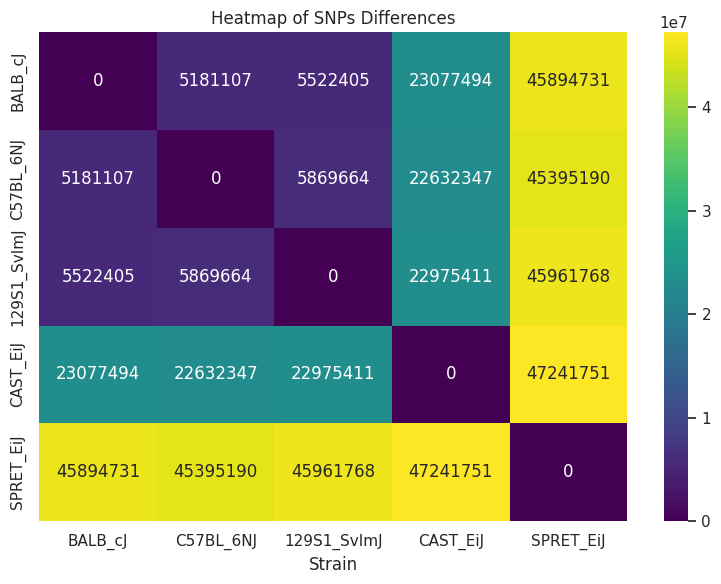

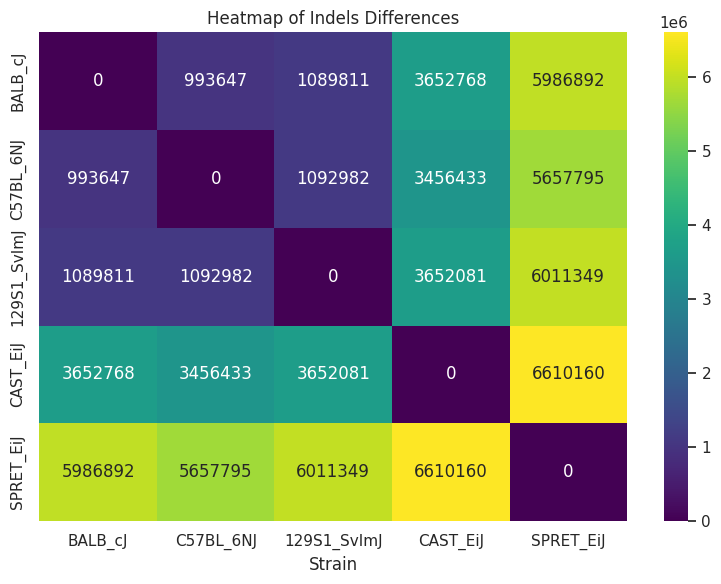

In [5]:
# 4. 히트맵 시각화
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='white')

for var_type in ['SNPs', 'Indels']:
    plt.figure(figsize=(8, 6))
    sns.heatmap(distance_matrices[var_type].astype(int), annot=True, fmt='d', cmap='viridis')
    plt.title(f"Heatmap of {var_type} Differences")
    plt.xlabel('Strain')
    plt.xlabel('Strain')
    plt.tight_layout()
    plt.show()